In [1]:
!pip install kaggle
!kaggle datasets download -d lantian773030/pokemonclassification
!unzip pokemonclassification.zip -d ./pokemonclassification

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./pokemonclassification/PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: ./pokemonclassification/PokemonData/Golbat/a35b4e8e603c485cb1975

In [39]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pokemons_dataset = datasets.ImageFolder(root="/content/pokemonclassification/PokemonData", transform=transform)

train_size = int(0.8 * len(pokemons_dataset))
test_size = len(pokemons_dataset) - train_size
train_dataset, test_dataset = random_split(pokemons_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = pokemons_dataset.classes
print("Classes:", class_names)
print("Number of classes:", len(class_names))

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Classes: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidok

In [16]:
len(class_names)

150

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_size = len(class_names)
model = LeNet(output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


def test_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

train_model(model, train_loader, criterion, optimizer, epochs=10)

test_model(model, test_loader, criterion)


Epoch 1/10: 100%|██████████| 171/171 [00:50<00:00,  3.40it/s]


Epoch 1, Loss: 4.6082, Accuracy: 2.55%


Epoch 2/10: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 2, Loss: 3.6435, Accuracy: 13.32%


Epoch 3/10: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 3, Loss: 2.8311, Accuracy: 28.06%


Epoch 4/10: 100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


Epoch 4, Loss: 2.2974, Accuracy: 39.37%


Epoch 5/10: 100%|██████████| 171/171 [00:50<00:00,  3.40it/s]


Epoch 5, Loss: 1.8987, Accuracy: 49.76%


Epoch 6/10: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 6, Loss: 1.6099, Accuracy: 56.25%


Epoch 7/10: 100%|██████████| 171/171 [00:50<00:00,  3.40it/s]


Epoch 7, Loss: 1.4030, Accuracy: 61.62%


Epoch 8/10: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 8, Loss: 1.1875, Accuracy: 66.68%


Epoch 9/10: 100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


Epoch 9, Loss: 1.0896, Accuracy: 69.26%


Epoch 10/10: 100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


Epoch 10, Loss: 0.9549, Accuracy: 72.16%
Test Loss: 2.7565, Accuracy: 45.60%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4575
Precision: 0.5033
Recall: 0.4550


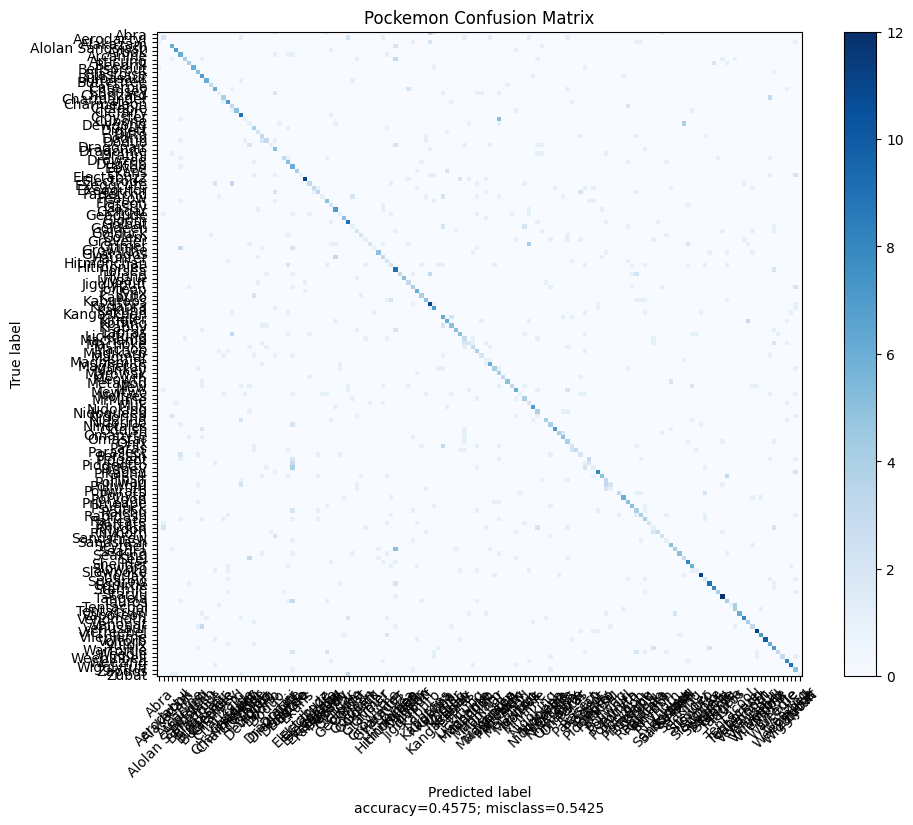

In [47]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np


def test_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return all_preds, all_labels


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

model = model.to("cuda")
all_preds, all_labels = test_model(model, test_loader)

cm = confusion_matrix(all_labels, all_preds)

class_names = pokemons_dataset.classes
plot_confusion_matrix(cm, target_names=class_names, title="Pockemon Confusion Matrix")